In [1]:
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\Stefan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Load the dataset
df = pd.read_csv("data_grouped_raw.csv")

# Display basic info
print(df.shape)
df.head()

(31624, 21)


,repo,file,nloc,ccn_avg,ccn_std,num_functions,changes,authors,main_author_ratio,age_days,...,lines_added,lines_deleted,churn_rate,entropy,comment_density,bugfix_ratio,changes_per_kloc,fixes_per_age,fix_count,defective
0,https_github.com_apache_maven_metrics,impl/maven-core/src/main/java/org/apache/maven...,207,6.000000,3.464102,7,5,3,0.600000,364,...,377,94,2.264423,6.024480,0.123675,0.400000,4.142502,0.005479,2,1
1,https_github.com_apache_maven_metrics,impl/maven-impl/src/main/java/org/apache/maven...,2137,4.363636,6.954227,77,19,3,0.684211,273,...,2944,440,1.582788,2.286086,0.039137,0.315789,6.056742,0.021898,6,1
2,https_github.com_apache_maven_metrics,its/core-it-suite/src/test/java/org/apache/mav...,16,1.000000,0.000000,2,1,1,1.000000,8,...,76,0,4.470588,1.791759,0.697368,1.000000,0.984252,0.111111,1,1
3,https_github.com_apache_maven_metrics,its/core-it-suite/src/test/java/org/apache/mav...,785,1.125000,0.330719,8,89,14,0.303371,1120,...,2430,754,4.050891,2.356120,0.050648,0.191011,49.859944,0.015165,17,1
4,https_github.com_apache_maven_metrics,its/core-it-suite/src/test/resources/gh-11280-...,6,1.000000,0.000000,1,1,1,1.000000,8,...,31,0,4.428571,1.791759,0.741935,1.000000,0.994036,0.111111,1,1


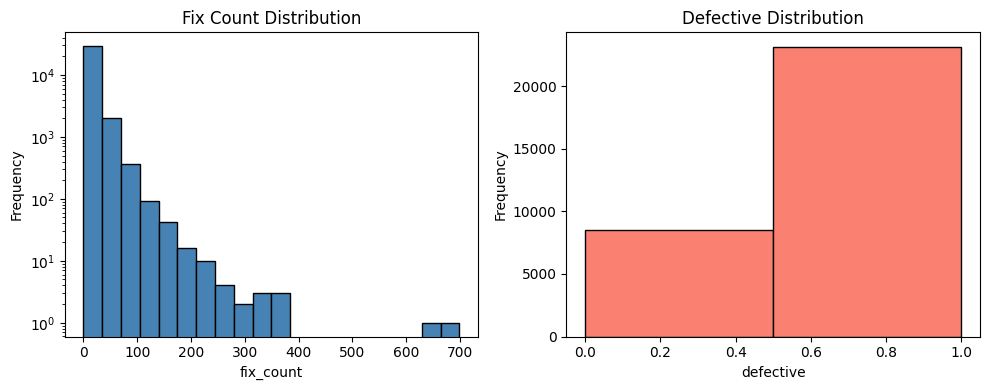

In [4]:
# Set up the figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram for fix_count
axes[0].hist(df['fix_count'], bins=20, color='steelblue', edgecolor='black')
axes[0].set_title('Fix Count Distribution')
axes[0].set_xlabel('fix_count')
axes[0].set_yscale('log')
axes[0].set_ylabel('Frequency')

# Histogram for defective (binary)
axes[1].hist(df['defective'], bins=2, color='salmon', edgecolor='black')
axes[1].set_title('Defective Distribution')
axes[1].set_xlabel('defective')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Fixing class imbalance

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Separate minority and majority classes
minority = df[df['defective'] == 0]
majority = df[df['defective'] == 1]

print(f"Before balancing: {len(minority)} class 0, {len(majority)} class 1")

# === Step 1: Select only numeric columns for clustering ===
num_cols = df.select_dtypes(include=[np.number]).columns.drop('defective')
X_majority = majority[num_cols]

# === Step 2: Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_majority)

# === Step 3: Choose number of clusters ≈ minority size ===
n_clusters = len(minority)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
majority['cluster'] = kmeans.fit_predict(X_scaled)

# === Step 4: Pick one representative per cluster ===
balanced_majority = majority.groupby('cluster').apply(lambda g: g.sample(1, random_state=42)).reset_index(drop=True)

# === Step 5: Combine with minority ===
df_balanced = pd.concat([minority, balanced_majority], ignore_index=True)
print(f"After balancing: {df_balanced['defective'].value_counts().to_dict()}")


Before balancing: 8476 class 0, 23148 class 1


C:\Users\Stefan\AppData\Local\Temp\ipykernel_11100\947183916.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  majority['cluster'] = kmeans.fit_predict(X_scaled)


After balancing: {0: 8476, 1: 8476}


C:\Users\Stefan\AppData\Local\Temp\ipykernel_11100\947183916.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_majority = majority.groupby('cluster').apply(lambda g: g.sample(1, random_state=42)).reset_index(drop=True)


In [6]:
# Compare variance before and after balancing
var_before = df[num_cols].var()
var_after = df_balanced[num_cols].var()

variance_change = ((var_after - var_before) / var_before * 100).round(2)
print("Variance change (%) per feature:")
display(variance_change.sort_values(ascending=False))

Variance change (%) per feature:


lines_deleted        84.83
lines_added          84.48
nloc                 81.69
num_functions        77.57
ccn_std              67.69
ccn_avg              57.30
churn_rate           56.77
last_mod_days        52.52
fix_count            50.90
changes              45.62
fixes_per_age        31.20
entropy              24.20
main_author_ratio    21.91
changes_per_kloc     18.77
comment_density      16.88
authors              15.04
age_days              4.66
bugfix_ratio        -10.37
dtype: float64

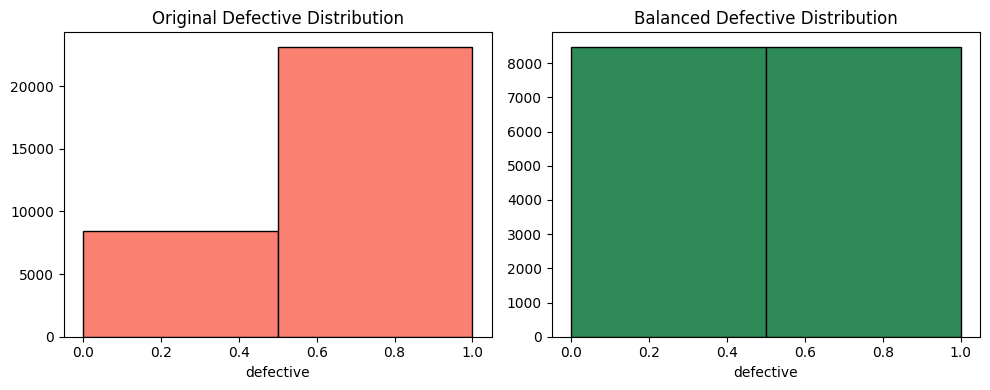

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(df['defective'], bins=2, color='salmon', edgecolor='black')
axes[0].set_title('Original Defective Distribution')
axes[0].set_xlabel('defective')

axes[1].hist(df_balanced['defective'], bins=2, color='seagreen', edgecolor='black')
axes[1].set_title('Balanced Defective Distribution')
axes[1].set_xlabel('defective')

plt.tight_layout()
plt.show()

In [8]:
from scipy.stats import ks_2samp, entropy
import numpy as np
import pandas as pd

def jensen_shannon_divergence(p, q, bins=30):
    """Compute JS divergence between two numeric distributions."""
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    # Normalize to avoid divide-by-zero
    p_hist = np.where(p_hist == 0, 1e-12, p_hist)
    q_hist = np.where(q_hist == 0, 1e-12, q_hist)
    m = 0.5 * (p_hist + q_hist)
    return 0.5 * (entropy(p_hist, m) + entropy(q_hist, m))

# Compute KS statistic and JS divergence per feature
results = []
for col in num_cols:
    ks_stat, ks_p = ks_2samp(df[col], df_balanced[col])
    js_div = jensen_shannon_divergence(df[col], df_balanced[col])
    results.append((col, ks_stat, ks_p, js_div))

similarity_df = pd.DataFrame(results, columns=["feature", "KS_stat", "KS_p_value", "JS_divergence"])
similarity_df = similarity_df.sort_values(by="JS_divergence")

print("Feature distribution similarity before vs after balancing:")
display(similarity_df)

Feature distribution similarity before vs after balancing:


,feature,KS_stat,KS_p_value,JS_divergence
10,lines_deleted,0.112437,5.541548e-122,0.000074
9,lines_added,0.162912,2.120393e-256,0.000143
11,churn_rate,0.184713,0.000000e+00,0.000205
3,num_functions,0.040072,7.799422e-16,0.000398
0,nloc,0.034083,1.422315e-11,0.000430
16,fixes_per_age,0.232058,0.000000e+00,0.001306
17,fix_count,0.231976,0.000000e+00,0.001662
2,ccn_std,0.044370,2.564211e-19,0.001767
1,ccn_avg,0.049033,1.693138e-23,0.002203
13,comment_density,0.044372,2.553278e-19,0.002762


In [11]:
# Drop the cluster column if it exists
if 'cluster' in df_balanced.columns:
    df_balanced = df_balanced.drop(columns=['cluster'])

In [12]:
# Save the balanced dataframe to CSV
df_balanced.to_csv("data_grouped_balanced.csv", index=False)

In [13]:
# Keep only numeric columns
df_numeric = df_balanced.select_dtypes(include=[float, int])

# Show shape and preview
print(df_numeric.shape)
df_numeric.head()


(16952, 19)


,nloc,ccn_avg,ccn_std,num_functions,changes,authors,main_author_ratio,age_days,last_mod_days,lines_added,lines_deleted,churn_rate,entropy,comment_density,bugfix_ratio,changes_per_kloc,fixes_per_age,fix_count,defective
0,23,1.000,0.000000,4,3,1,1.000000,386,9,70,1,2.958333,3.715977,0.579710,0.0,2.932551,0.0,0,0
1,6,1.000,0.000000,1,1,1,1.000000,9,9,27,0,3.857143,2.302585,0.666667,0.0,0.994036,0.0,0,0
2,6,1.000,0.000000,1,1,1,1.000000,9,9,27,0,3.857143,2.302585,0.666667,0.0,0.994036,0.0,0,0
3,727,2.875,3.731203,64,7,5,0.428571,351,9,1169,9,1.618132,4.614932,0.268966,0.0,4.053272,0.0,0,0
4,87,1.000,0.000000,6,7,5,0.285714,6216,9,406,117,5.943182,3.799703,0.268456,0.0,6.439742,0.0,0,0


In [18]:
# Drop the specified columns if they exist
cols_to_drop = ['fixes_per_age', 'fix_count']
df = df_balanced.drop(columns=[c for c in cols_to_drop if c in df_balanced.columns])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.select_dtypes(include=[np.number])
df.head()


,nloc,ccn_avg,ccn_std,num_functions,changes,authors,main_author_ratio,age_days,last_mod_days,lines_added,lines_deleted,churn_rate,entropy,comment_density,bugfix_ratio,changes_per_kloc,defective
0,55,1.000000,0.000000,6,2,2,0.500000,385,117,75,0,1.339286,4.451636,0.053333,0.500000,1.895735,1
1,29,7.000000,0.000000,1,2,1,1.000000,266,56,57,3,2.000000,4.310236,0.370370,0.000000,1.943635,0
2,29,1.000000,0.000000,1,71,14,0.366197,2750,1938,1237,625,62.066667,3.592081,0.000000,0.084507,68.999028,1
3,129,1.214286,0.557875,14,3,1,1.000000,364,38,240,14,1.953846,6.131597,0.269912,0.000000,2.657219,0
4,0,0.000000,0.000000,0,2,2,0.500000,4624,4573,0,0,0.000000,7.649693,0.000000,0.000000,2.000000,0


## Training

In [19]:
from sklearn.model_selection import train_test_split

# Split 80/20
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")
train_df.head()

Train size: 13561, Validation size: 3391


,nloc,ccn_avg,ccn_std,num_functions,changes,authors,main_author_ratio,age_days,last_mod_days,lines_added,lines_deleted,churn_rate,entropy,comment_density,bugfix_ratio,changes_per_kloc,defective
16158,52,1.5,0.500000,4,2,2,0.500000,4038,3939,110,110,4.150943,8.595984,0.303922,0.000000,1.901141,0
3647,89,1.0,0.000000,13,17,11,0.176471,752,206,446,35,5.344444,3.433571,0.495370,0.058824,15.610652,1
1743,11,1.0,0.000000,5,1,1,1.000000,385,385,22,0,1.833333,7.516977,0.181818,0.000000,0.989120,0
3950,70,2.5,2.598076,4,29,12,0.413793,1011,344,1915,16,27.197183,1.993805,0.252336,0.068966,27.102804,1
16521,27,1.0,0.000000,5,12,4,0.666667,6930,1392,294,178,16.857143,6.388032,0.460317,0.083333,11.684518,1


### SVM

In [21]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split features and labels
X_train = train_df.drop(columns=['defective'])
y_train = train_df['defective']
X_val = val_df.drop(columns=['defective'])
y_val = val_df['defective']

# Create a pipeline with scaling + SVM
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
)

# Train
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_val)

# Evaluate
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.9988

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1680
           1       1.00      1.00      1.00      1711

    accuracy                           1.00      3391
   macro avg       1.00      1.00      1.00      3391
weighted avg       1.00      1.00      1.00      3391

Confusion Matrix:
 [[1676    4]
 [   0 1711]]


In [70]:
import joblib

# Save the trained SVM pipeline
joblib.dump(svm_model, "svm_model.pkl")

['svm_model.pkl']

In [72]:
# Load the saved model
svm_model_loaded = joblib.load("svm_model.pkl")

# Example: predict with loaded model
y_pred_loaded = svm_model_loaded.predict(X_val)
y_pred_loaded.shape

(3391,)

In [63]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Reduce features to 2D with PCA
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train)
X_val_2d = pca.transform(X_val)

# Train a new SVM on 2D data (for visualization only)
svm_2d = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_2d.fit(X_train_2d, y_train)

SVC(random_state=42)

In [64]:
# Create a meshgrid
x_min, x_max = X_val_2d[:, 0].min() - 1000, X_val_2d[:, 0].max() + 1000
y_min, y_max = X_val_2d[:, 1].min() - 1000, X_val_2d[:, 1].max() + 1000
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on grid
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

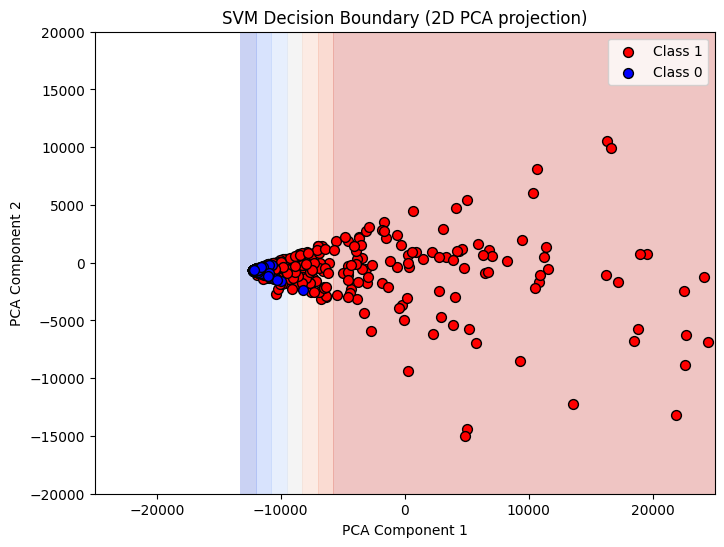

In [68]:
import matplotlib.patches as mpatches

N=500
# Scatter plot
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_val_2d[:,0][y_val==1][:N], X_val_2d[:,1][y_val==1][:N], c='red', label='Class 1', edgecolor='k', s=50)
plt.scatter(X_val_2d[:,0][y_val==0][:N], X_val_2d[:,1][y_val==0][:N], c='blue', label='Class 0', edgecolor='k', s=50)
plt.title("SVM Decision Boundary (2D PCA projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.xlim(-25000,25000)
plt.ylim(-20000,20000)
plt.show()


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Prepare data
X_train_nn = X_train.values
y_train_nn = y_train.values
X_val_nn = X_val.values
y_val_nn = y_val.values

# Build a simple MLP
nn_model = Sequential([
    Dense(64, input_dim=X_train_nn.shape[1], activation='leaky_relu'),
    Dropout(0.2),
    Dense(32, activation='leaky_relu'),
    Dropout(0.1),
    Dense(16, activation='leaky_relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
nn_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Train
history = nn_model.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=25,
    batch_size=64,
    verbose=1
)

# Evaluate
val_loss, val_acc = nn_model.evaluate(X_val_nn, y_val_nn, verbose=0)
print(f"\nValidation Accuracy: {val_acc:.4f}")


Epoch 1/25
212/212 [==============================] - 5s 8ms/step - loss: 37.0989 - accuracy: 0.7067 - val_loss: 2.7120 - val_accuracy: 0.8307
Epoch 2/25
212/212 [==============================] - 1s 7ms/step - loss: 7.9020 - accuracy: 0.7492 - val_loss: 2.7511 - val_accuracy: 0.8077
Epoch 3/25
212/212 [==============================] - 1s 7ms/step - loss: 5.7398 - accuracy: 0.7685 - val_loss: 1.5817 - val_accuracy: 0.8434
Epoch 4/25
212/212 [==============================] - 2s 7ms/step - loss: 3.9723 - accuracy: 0.7670 - val_loss: 1.1921 - val_accuracy: 0.8354
Epoch 5/25
212/212 [==============================] - 1s 7ms/step - loss: 2.7697 - accuracy: 0.7836 - val_loss: 0.8720 - val_accuracy: 0.8558
Epoch 6/25
212/212 [==============================] - 1s 6ms/step - loss: 2.2714 - accuracy: 0.7886 - val_loss: 0.7716 - val_accuracy: 0.8582
Epoch 7/25
212/212 [==============================] - 1s 7ms/step - loss: 2.0783 - accuracy: 0.8016 - val_loss: 0.5736 - val_accuracy: 0.8694
Epoch